# EECS 4404 / 5327: Mental Health Text Classifier Project (Group U)

Our model was trained on social media posts. The length of each post ranged between two to five sentences. As a result, very short one-liner sentences tend to get misclassified.

We used a combination of trial-and-error and GridSearchCV to tune our Deep Forest Classifier.

- Shogo Toyonaga
- Abel Habte
- Dongwon Lee
- Jonathan Ramos


## Install Requirements

In [2]:
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install sklearn
%pip install seaborn
%pip install wordcloud
%pip install transformers datasets evaluate
!pip install playwright
!pip install beautifulsoup4
!pip install nest-asyncio
!playwright install

  error: subprocess-exited-with-error
  
  √ó python setup.py egg_info did not run successfully.
  ‚îÇ exit code: 1
  ‚ï∞‚îÄ> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

√ó Encountered error while generating package metadata.
‚ï∞‚îÄ> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 521.2/521.2 kB 4.0 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 84.1/84.1 kB 12.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ

## Imports

In [3]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sb
from wordcloud import WordCloud, STOPWORDS
from google.colab import drive
import time
# Tokenizers
from sklearn.feature_extraction.text import TfidfVectorizer
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Web Scraping
import requests
from collections import Counter
import statistics
from playwright.async_api import async_playwright, Playwright
import time
from bs4 import BeautifulSoup
import nest_asyncio
nest_asyncio.apply()

In [4]:
# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Auxiliary Methods (i.e., Graph Generators)

In [5]:
def generate_heatmap(test_y, labels, train_y):
    sb.set()
    mat = confusion_matrix(test_y, labels)
    sb.heatmap(mat.T, square=True, annot=False, fmt='d',
               cbar=True,
               xticklabels=train_y.unique(),
               yticklabels=train_y.unique(),
               cmap='crest'
              )
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')

In [6]:
def predict_user_mental_wellbeing(m) -> str:
  analysis = "\n"
  results = model.predict_proba([user_message])
  for i in range(len(model.classes_)):
    analysis += str(model.classes_[i]) + " : " + str(results[0][i]) + "\n"
  return analysis

In [7]:
def evaluate_model(sk_model):
  print("Model Score on Training Data: " + str(round(sk_model.score(train_X, train_y), 2)))
  # labels = sk_model.predict(test_X)
  print("Model Score on Testing Data: " + str(round(sk_model.score(test_X, test_y), 2)))

## Data and Model Preprocessing

In [8]:
messages = pd.read_csv('drive/MyDrive/Suicide_Detection.csv', engine='python', encoding='utf-8', on_bad_lines='skip')
messages.dropna(axis=0)
messages.info()
print("Dimension of the Dataset: " + str(messages.shape))
X = messages['text']
y = messages['class']
print("Y counts:\n" + str(y.value_counts()))
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB
Dimension of the Dataset: (232074, 3)
Y counts:
suicide        116037
non-suicide    116037
Name: class, dtype: int64


In [10]:
"""
These hyperparameters have been found by using GridSearchCV
Originally, we noticed Overfitting as the test score was 1.0 and the training, 0.5.
This seemed to fix the problem very well :)
"""
model = Pipeline(steps=[
    ('text', TfidfVectorizer()),
    ('df', RandomForestClassifier(
        n_estimators=500,
        max_depth=125,
        min_samples_leaf=5,
        # oob_score=True
        n_jobs=-1,
        # n_estimators=500,
        # max_depth=151,
        # min_samples_leaf=1
    ))
])

## Model Training

In [11]:
model.fit(train_X, train_y)

Pipeline(steps=[('text', TfidfVectorizer()),
                ('df',
                 RandomForestClassifier(max_depth=125, min_samples_leaf=5,
                                        n_estimators=500, n_jobs=-1))])

In [12]:
evaluate_model(model)

Model Score on Training Data: 0.88
Model Score on Testing Data: 0.86


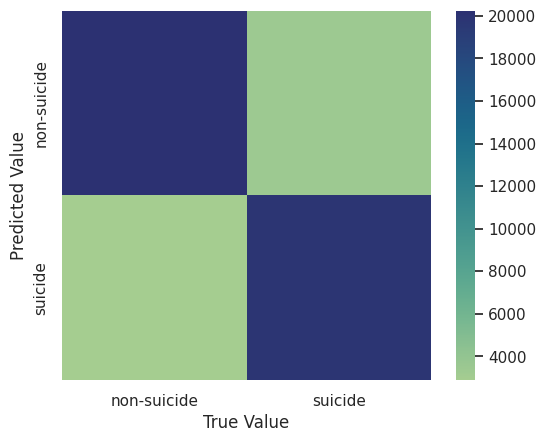

In [13]:
labels = model.predict(test_X)
generate_heatmap(test_y, labels, train_y)

## Model Generalizability (GUI Interface)

In [ ]:
"""
Prompt Examples:
Mental Distress: I don't understand why I have to put up with this. i hate myself i'm always alone. I avoid my family and feel like life is absolutely hopeless. I don't enjoy playing games anymore. Nothing is fun anymore. I‚Äôve tried other games but shit it only lasts for an hour. The only thing that i like is Astronomy. But otherwise i feel hopeless. My family probably hates me to.
Prompt: 'Happy, Happy, Joy, Joy'
"""
user_message = 'hello world' # @param {type:"string"}
results = model.predict_proba([user_message])
for i in range(len(model.classes_)):
    print(str(model.classes_[i]) + " : " + str(results[0][i]))

non-suicide : 0.8200832921652514
suicide : 0.17991670783474836


In [ ]:
model.predict(['Happy, Happy, Joy, Joy!'])

array(['non-suicide'], dtype=object)

## Random Forest (Hyperparameter Tuning)

In [ ]:
hyperparameters = {
    'df__n_estimators': [i for i in range(250, 750, 250)],
    'df__max_depth': [i for i in range(1, 200, 50)],
    'df__min_samples_leaf': [i for i in range(1, 5)]
}

In [ ]:
search = GridSearchCV(
    estimator=model,
    param_grid=hyperparameters,
    cv=5,
    n_jobs=-1,
    verbose=True
)

"""
Fitting 5 folds for each of 32 candidates, totalling 160 fits
FOUND Best Random Forest Classifier with Hyperparameters: {'df__max_depth': 151, 'df__min_samples_leaf': 1, 'df__n_estimators': 500}
0.8709375000000001
"""

"\nFitting 5 folds for each of 32 candidates, totalling 160 fits\nFOUND Best Random Forest Classifier with Hyperparameters: {'df__max_depth': 151, 'df__min_samples_leaf': 1, 'df__n_estimators': 500}\n0.8709375000000001\n"

In [ ]:
search.fit(train_X, train_y)
print("FOUND Best Random Forest Classifier with Hyperparameters: " + str(search.best_params_))
print(search.best_score_)
best_df = search.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: ignored

## Reddit WebScraper (Shogo)

In [16]:
subreddit_id = "depression" #@param {type:"string"}
topic_classifier = "top" #@param ['top', 'hot', 'new'] {allow-input: true}

url = "https://www.reddit.com/r/{}/{}".format(subreddit_id, topic_classifier)
print("Requesting information (json file) from {}...".format(url))

headers = {
    'User-Agent': 'shogz-bot'
}

response = requests.get(url + ".json", headers=headers)
if response.ok:
  data = response.json()['data']
  reddit_title = []
  reddit_text = []
  reddit_post_classification = []
  for post in data['children']:
    reddit_title.append(post['data']['title'])
    reddit_text.append(post['data']['selftext'])
    reddit_post_classification.append(model.predict([post['data']['selftext']])[0])
  print("Number of scraped posted: {}".format(len(reddit_title)))
  view_number_of_comments = int(input("Number of Comments to Test:"))
  for i in range(view_number_of_comments):
    print("---------- Analysis of Comment {} ----------".format(i + 1))
    # print("Post Title: {}\nContent:{}\n\nAnalysis:{}\n".format(reddit_title[i], reddit_text[i], predict_user_mental_wellbeing(reddit_text[i])))
    print("Post Title: {}\nContent:{}\n\nClassification:{}\n".format(reddit_title[i], reddit_text[i], model.predict([reddit_text[i]])))
else:
  print('Error {}'.format(response.status_code))

Requesting information (json file) from https://www.reddit.com/r/depression/top...
Error 403


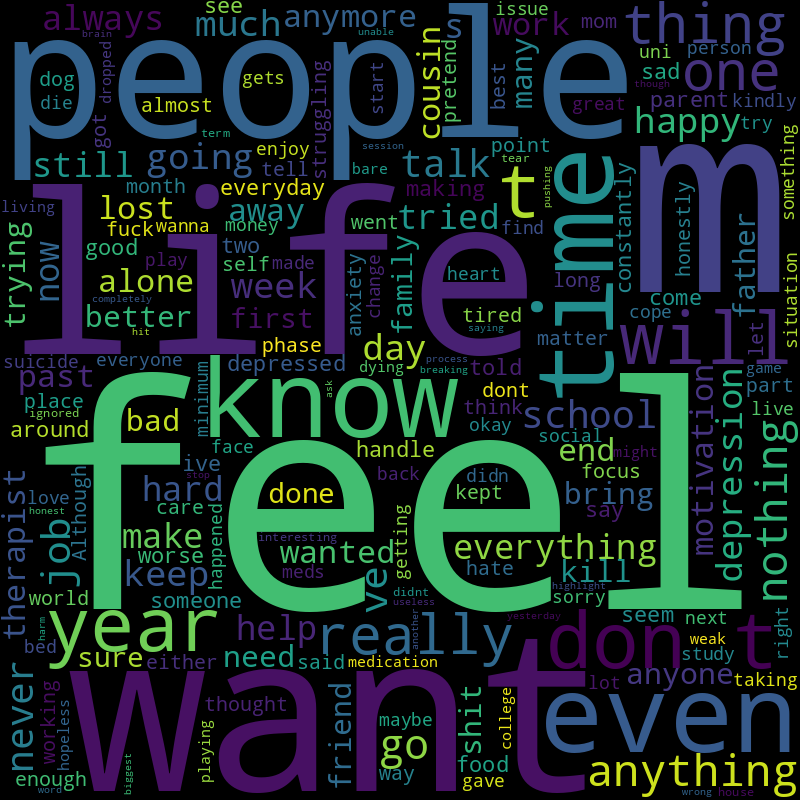

In [ ]:
words_visualization = WordCloud(
    background_color='black',
    width=800,
    height=800,
)
words_visualization.generate(' '.join(word for word in reddit_text))
words_visualization.to_image()

Text(0.5, 1.0, 'Classification of Reddit Posts\nfrom Scraping r/depression based on new posts')

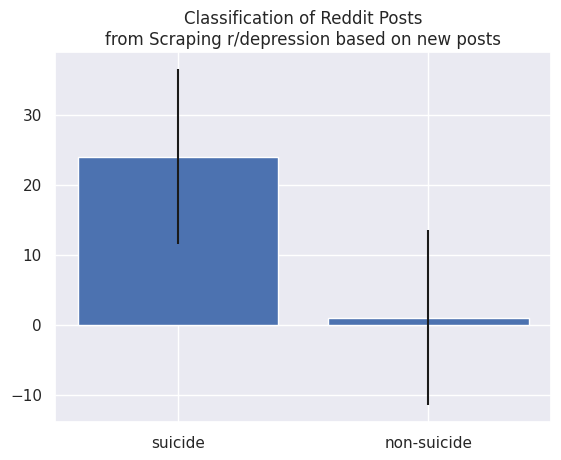

In [ ]:
stats = Counter(reddit_post_classification)
plt.bar(x=stats.keys(),
        height=stats.values(),
        yerr=statistics.mean(stats.values())
        )
plt.title("Classification of Reddit Posts\nfrom Scraping r/{} based on {} posts".format(subreddit_id, topic_classifier))

## Quora Web Scraping (Shogo & Abel)

In [ ]:
import asyncio
from playwright.async_api import async_playwright, Playwright

async def run(playwright: Playwright):
    chromium = playwright.chromium # or "firefox" or "webkit".
    browser = await chromium.launch()
    page = await browser.new_page()
    link = 'https://www.quora.com/What-is-real-meaning-of-derivative' # @param {type:"string"}
    number_of_long_posts = 10 # @param {type:"number"}
    min_post_length_in_chars = 50 # @param {type:"number"}
    loading_time = 2 # @param {type:"number"}

    await page.goto(link)
    print("Sleeping for {} seconds (page loading)".format(loading_time))
    time.sleep(loading_time)
    for i in range(number_of_long_posts):
      try:
        button = await page.get_by_text("Continue Reading", exact=True).nth(i).click()
        print("Post #{} has been expanded...".format(i + 1))
      except:
        print("Not enough post data!! We scraped what was available to us.")
        break
      await page.mouse.wheel(0,100)
    html = page.inner_html("#mainContent")
    parser = BeautifulSoup(await html, "html.parser")
    posts = parser.find_all("div", {"class": "q-box spacing_log_answer_content puppeteer_test_answer_content"})
    answers = []
    for post in posts:
      if len(post.text.strip()) > min_post_length_in_chars:
        answers.append(post.text.strip())
    print("After pruning, {} posts (text-only) remain.".format(len(answers)))
    for entry in answers:
      print("---------- Post ----------\nClassification:{}\n{}\n---------------".format(model.predict([entry]), entry))
    await browser.close()

async def main():
    async with async_playwright() as playwright:
        await run(playwright)
asyncio.run(main())

Sleeping for 2 seconds (page loading)
Post #1 has been expanded...
Post #2 has been expanded...
Post #3 has been expanded...
Post #4 has been expanded...
Post #5 has been expanded...
Post #6 has been expanded...
Post #7 has been expanded...
Post #8 has been expanded...
Post #9 has been expanded...
Post #10 has been expanded...
After pruning, 33 posts (text-only) remain.
---------- Post ----------
Classification:['non-suicide']
Associated to a function  ff  is a derivative function  f‚Ä≤,f‚Ä≤, that is to say, its derived function. Whereas the function gives a value  f(x)f(x)  for each value of  x,x,  the derivative  f‚Ä≤(x)f‚Ä≤(x)  tells you the rate of change of that value at  x.x.  That's all the derivative is.  It's the rate of change of something. For example, f(t)f(t)  may specify the position of a moving point on a line at time  t,t,  and then  f‚Ä≤(t)f‚Ä≤(t)  gives the velocity of that point at time  t.t.
---------------
---------- Post ----------
Classification:['non-suicide']
A

# Website model prediction (Jon)


In [ ]:
!pip install joblib


In [ ]:
#Mount the drive for grabbing the model
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
import os
model_dir = "/content/gdrive/My Drive"
os.makedirs(model_dir, exist_ok=True)

In [ ]:
#Save model, only need to do it when running for the firs time
import joblib

# Save the model to Google Drive using joblib
#joblib.dump(model, "/content/gdrive/My Drive/randomForest.pkl")

# Base Models (Jon)

In [17]:
# Base Models Go Here
from sklearn.linear_model import LogisticRegression

base_rf = Pipeline(steps=[
    ('text', TfidfVectorizer()),
    ('rf', RandomForestClassifier(
        # Use all cores to speed up fitting process
        n_jobs=-1
        ))
])

# Base Models Go Here

base_nb = Pipeline(steps=[
    ('text1', TfidfVectorizer()),
    ('rf', MultinomialNB())
])

base_gb = Pipeline(steps=[
    ('text2', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier())
])

base_ab = Pipeline(steps=[
    ('text3', TfidfVectorizer()),
    # Default Neighbour set to 5
    ('ab', AdaBoostClassifier())
])

base_lsvm = Pipeline(steps=[
    ('text4', TfidfVectorizer()),
    ('lsvm', SVC(kernel='linear'))
])

#Logistic regression
base_lr = Pipeline(steps=[
    ('text5', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=1000))  # Increase max_iter value
])

In [ ]:
start = time.time()
base_rf.fit(train_X, train_y)
end = time.time()
print("Time to fit model: " + str(round((end - start) / 60, 2)) + " minutes.")
evaluate_model(base_rf)

In [ ]:
start = time.time()
base_nb.fit(train_X, train_y)
end = time.time()
print("Time to fit model: " + str(round((end - start) / 60, 2)) + " minutes.")
evaluate_model(base_nb)

In [ ]:
param_grid = {
    'rf__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
}

grid_search = GridSearchCV(base_nb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_X, train_y)

best_alpha = grid_search.best_params_['rf__alpha']
best_nb_model = grid_search.best_estimator_


In [ ]:
#Evaluate the model with tuned parameters
evaluate_model(best_nb_model)

In [ ]:
joblib.dump(best_nb_model, "/content/gdrive/My Drive/naiveBayes.pkl")

['/content/gdrive/My Drive/naiveBayes.pkl']

In [ ]:
start = time.time()
base_gb.fit(train_X, train_y)
end = time.time()
print("Time to fit model: " + str(round((end - start) / 60, 2)) + " minutes.")
evaluate_model(base_gb)

In [ ]:
start = time.time()
base_ab.fit(train_X, train_y)
end = time.time()
print("Time to fit model: " + str(round((end - start) / 60, 2)) + " minutes.")
evaluate_model(base_ab)

In [ ]:
start = time.time()
base_lsvm.fit(train_X, train_y)
end = time.time()
print("Time to fit model: " + str(round((end - start) / 60, 2)) + " minutes.")
evaluate_model(base_ab)

In [ ]:
#Tuning for LVSM above
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1],
}

grid_search = GridSearchCV(estimator=base_lsvm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# Measure time to fit the model
start = time.time()
grid_search.fit(train_X, train_y)
end = time.time()

print("Best hyperparameters: " + str(grid_search.best_params_))
print("Time to fit model: " + str(round((end - start) / 60, 2)) + " minutes.")

# Evaluate the best model
best_lsvm_model = grid_search.best_estimator_
evaluate_model(best_lsvm_model)


**Train Logistic Regression**



In [ ]:
#First time train for Logistic Regression
start = time.time()
base_lr.fit(train_X, train_y)
end = time.time()
print("Time to fit model: " + str(round((end - start) / 60, 2)) + " minutes.")

In [ ]:
evaluate_model(base_lr)

In [ ]:
#Tuning for logistic regression
param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'lr__penalty': ['l1', 'l2'],  # Penalty type
    'lr__solver': ['liblinear', 'lbfgs', 'sag', 'saga']  # Solver method
}

grid_search = GridSearchCV(base_lr, param_grid, cv=5, n_jobs=-1)
# Measure time to fit the model
start = time.time()
grid_search.fit(train_X, train_y)
end = time.time()

print("Best hyperparameters: " + str(grid_search.best_params_))
print("Time to fit model: " + str(round((end - start) / 60, 2)) + " minutes.")

best_lr_model = grid_search.best_estimator_
evaluate_model(best_lr_model)


In [ ]:
joblib.dump(base_lr, "/content/gdrive/My Drive/logisticRegression.pkl")
#joblib.dump(best_lr_model, "/content/gdrive/My Drive/logisticRegression.pkl") #wouldn't fine tune the parameters..

['/content/gdrive/My Drive/logisticRegression.pkl']

**Google sheets predictions**

In [ ]:
!pip install --upgrade gspread


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 48.5/48.5 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 3.4.2
    Uninstalling gspread-3.4.2:
      Successfully uninstalled gspread-3.4.2


In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds,_ = default()

gs = gspread.authorize(creds)

worksheet = gs.open_by_key("13iuYASrK4oeUY-iVZnejvd6yndolZLQ2LtO_crGffkg").sheet1


In [ ]:
import joblib
from keras.models import load_model

randomForestModel = joblib.load("/content/gdrive/My Drive/randomForest.pkl")
naiveBayesModel = joblib.load("/content/gdrive/My Drive/naiveBayes.pkl")
logisticRegressionModel = joblib.load("/content/gdrive/My Drive/logisticRegression.pkl")

In [ ]:
def update_google_sheet(website_name, subreddit_id, comments, model_classifications, model2_classifications, model3_classifications):
    # Get the existing data in the sheet
    existing_data = worksheet.get_all_values()

    # If the sheet is empty, add the header row
    if not existing_data:
        header_row = ["Website","Subreddit", "Comment", "Random Forest Prediction", "Naive Bayes Prediction", "Logistic Regression Prediction", "My Prediction"]
        existing_data.append(header_row)

    # Append the new data (comments and model classifications) if the comment is not empty
    new_rows = []
    for i in range(len(comments)):
        if comments[i]:  # Check if the comment is not empty
            new_row = [website_name, subreddit_id, comments[i], model_classifications[i], model2_classifications[i], model3_classifications[i], ""]
            new_rows.append(new_row)

    # Append the new rows to the existing data
    existing_data.extend(new_rows)

    # Update the Google Sheet with the new data
    worksheet.update(existing_data)


In [ ]:
subreddit_id = "mcgill" #@param {type:"string"}
topic_classifier = "new" #@param ['top', 'hot', 'new'] {allow-input: true}

url = "https://www.reddit.com/r/{}/{}".format(subreddit_id, topic_classifier)
print("Requesting information (json file) from {}...".format(url))

headers = {
    'User-Agent': 'shogz-bot'
}

response = requests.get(url + ".json", headers=headers)
if response.ok:
  data = response.json()['data']
  reddit_title = []
  reddit_text = []
  reddit_post_classification = []
  for post in data['children']:
    reddit_title.append(post['data']['title'])
    reddit_text.append(post['data']['selftext'])
  #print("Number of scraped posted: {}".format(len(reddit_title)))
  view_number_of_comments = int(input("Number of Comments to Test:"))
else:
  print('Error {}'.format(response.status_code))

Requesting information (json file) from https://www.reddit.com/r/mcgill/new...
Number of Comments to Test:50


In [ ]:
update_google_sheet("reddit", subreddit_id, reddit_text[:view_number_of_comments], randomForestModel.predict(reddit_text[:view_number_of_comments]), naiveBayesModel.predict(reddit_text[:view_number_of_comments]), logisticRegressionModel.predict(reddit_text[:view_number_of_comments]))

<ipython-input-60-6bdb1e79ec69>:21: DeprecationWarning: [Deprecated][in version 6.0.0]: Method signature's arguments 'range_name' and 'values' will change their order. We recommend using named arguments for minimal impact. In addition, the argument 'values' will be mandatory of type: 'List[List]'. (ex) Worksheet.update(values = [[]], range_name=) 
  worksheet.update(existing_data)


**Begin analysis**

In [ ]:
import pandas as pd
worksheet = gs.open_by_key("13iuYASrK4oeUY-iVZnejvd6yndolZLQ2LtO_crGffkg").sheet1

data = worksheet.get_all_values()
df = pd.DataFrame(data[1:], columns=data[0])  # Assuming the first row contains column names
df.head(5)


Website Subreddit                                            Comment  \
0  reddit     yorku                     Does anyone have the syllabus?   
1  reddit     yorku  We are currently recruiting participants for a...   
2  reddit     yorku  Question for those who graduated the 2nd entry...   
3  reddit     yorku  For those that graduated in October, have you ...   
4  reddit     yorku  Has anyone here successfully done it, and can ...   

  Random Forest Prediction Naive Bayes Prediction  \
0              non-suicide            non-suicide   
1              non-suicide            non-suicide   
2              non-suicide                suicide   
3              non-suicide                suicide   
4              non-suicide            non-suicide   

  Logistic Regression Prediction My Prediction  
0                    non-suicide   non-suicide  
1                    non-suicide   non-suicide  
2                    non-suicide   non-suicide  
3                    non-suicide   non-suicide  
4                    non-suicide   non-suicide

In [ ]:
df.tail(5)

Website Subreddit                                            Comment  \
88  reddit    mcgill  I know the hike doesn‚Äôt even current students ...   
89  reddit    mcgill  Hi,\n\nI have a class at the same time as math...   
90  reddit    mcgill  Hi everyone,\n\nI've been accepted to both Ude...   
91  reddit    mcgill  The TAs in PHIL classes seem to be allergic to...   
92  reddit    mcgill  Hi guys,\n\nis anyone looking for a member in ...   

   Random Forest Prediction Naive Bayes Prediction  \
88              non-suicide                suicide   
89              non-suicide            non-suicide   
90                  suicide            non-suicide   
91                  suicide            non-suicide   
92              non-suicide            non-suicide   

   Logistic Regression Prediction My Prediction  
88                    non-suicide   non-suicide  
89                    non-suicide   non-suicide  
90                    non-suicide   non-suicide  
91                    non-suicide   non-suicide  
92                    non-suicide   non-suicide

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_rf = accuracy_score(df['My Prediction'], df['Random Forest Prediction'])
accuracy_nb = accuracy_score(df['My Prediction'], df['Naive Bayes Prediction'])
accuracy_lr = accuracy_score(df['My Prediction'], df['Logistic Regression Prediction'])


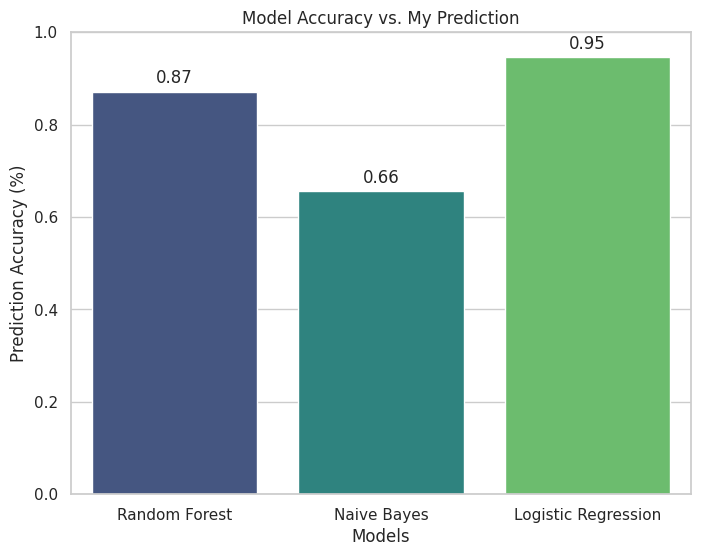

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

models = ['Random Forest', 'Naive Bayes', 'Logistic Regression']  # Add more models if needed
accuracies = [accuracy_rf, accuracy_nb, accuracy_lr]  # Add accuracy values for other models

data = {'Models': models, 'Accuracies': accuracies}

df = pd.DataFrame(data)
sns.set(style="whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.barplot(x='Models', y='Accuracies', data=df, palette='viridis')  # You can choose a different color palette

plt.ylim(0.0, 1.0)
plt.ylabel('Prediction Accuracy (%)')
plt.xlabel('Models')
plt.title('Model Accuracy vs. My Prediction')

# Annotate the bars with the accuracy values
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

models = ['Random Forest', 'Naive Bayes', 'Logistic Regression']  # Add more models if needed
accuracies = [accuracy_rf, accuracy_nb, accuracy_lr]  # Add accuracy values for other models

data = {'Models': models, 'Accuracies': accuracies}

df = pd.DataFrame(data)

plt.style.use('seaborn')  # Optional: Set Matplotlib style to mimic Seaborn

# Create a bar plot using Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size if needed
bars = ax.bar(df['Models'], df['Accuracies'])  # You can choose a different color

plt.ylim(0.0, 1.0)
plt.ylabel('Prediction Accuracy (%)')
plt.xlabel('Models')
plt.title('Model Accuracy vs. My Prediction')

# Annotate the bars with the accuracy values
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()


NameError: ignored

# Model Comparisons Visual

In [ ]:
def evaluate_model_info(sk_model):
  training_score = round(sk_model.score(train_X, train_y), 2)
  # labels = sk_model.predict(test_X)
  testing_score = round(sk_model.score(test_X, test_y), 2)
  return training_score, testing_score

In [ ]:
training_score_randomForest, testing_score_randomForest = evaluate_model_info(randomForestModel)
training_score_naiveBayes, testing_score_naiveBayes = evaluate_model_info(naiveBayesModel)
training_score_lr, testing_score_lr = evaluate_model_info(logisticRegressionModel)


In [ ]:
print(training_score_randomForest)
print(testing_score_randomForest)
print(training_score_naiveBayes)
print(testing_score_naiveBayes)
print(training_score_lr)
print(testing_score_lr)


0.88
0.86
0.94
0.91
0.95
0.94


<ipython-input-58-4d2bb8e1339e>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


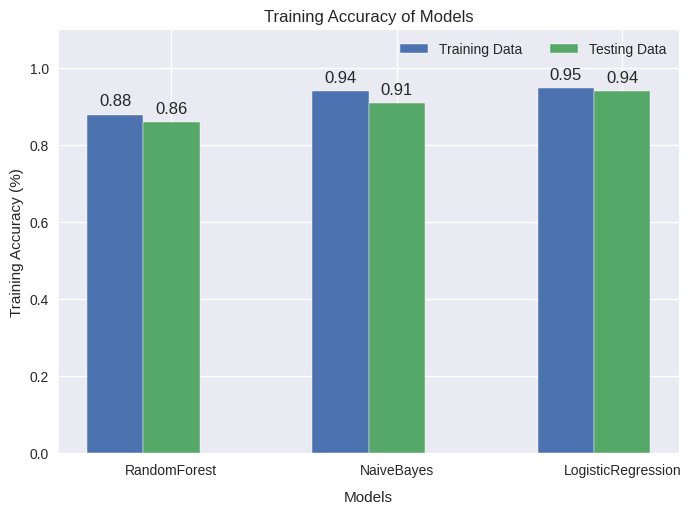

In [ ]:
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')

models = ('RandomForest', 'NaiveBayes', 'LogisticRegression')
accuracy_means = {
    'Training Data': (training_score_randomForest, training_score_naiveBayes, training_score_lr),
    'Testing Data': (testing_score_randomForest, testing_score_naiveBayes, testing_score_lr),
}

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in accuracy_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=4)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Accuracy (%)')
ax.set_xlabel('Models')
# ax.set_title('Models')
ax.set_xticks(x + width, models)
ax.xaxis.labelpad = 10
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 1.1)
ax.set_title("Training Accuracy of Models")
plt.show()

#Heatmaps

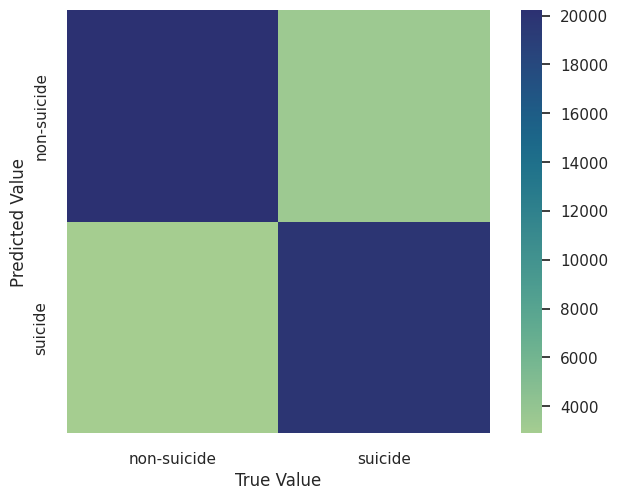

In [ ]:
labelRF = randomForestModel.predict(test_X)
generate_heatmap(test_y, labelRF, train_y)

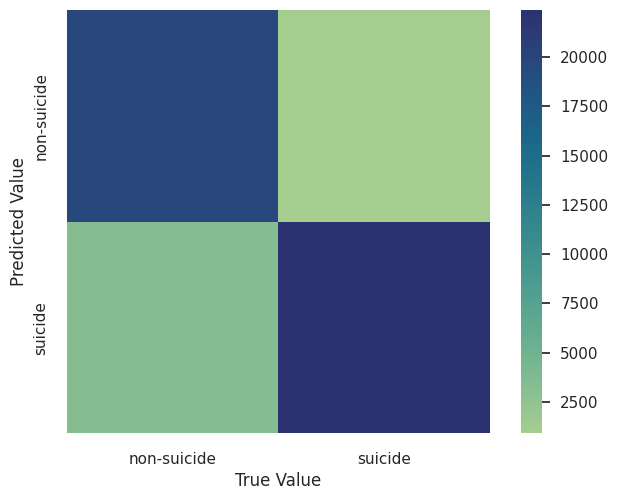

In [ ]:
labelNB = naiveBayesModel.predict(test_X)
generate_heatmap(test_y, labelNB, train_y)

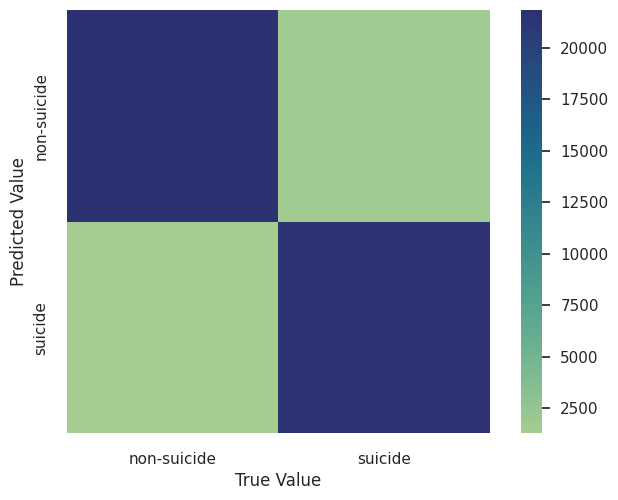

In [ ]:
labelLR = logisticRegressionModel.predict(test_X)
generate_heatmap(test_y, labelLR, train_y)

# Twitter Scraper
**Note:** Nitter blocks Google Colab from directly scraping the website. If you use the Twitter Scraping functionality, this code should be run on your own machine. If the page still has problems loading, use a VPN (i.e., Mullvad). Your access to the site will be blocked if you spam too many requests.

In [ ]:
from playwright.sync_api import sync_playwright
from bs4 import BeautifulSoup
import time
import re
"""
Sample Twitter Scraper
"""

# Avoid Memory Leak (Close Operation Once Completed)
with sync_playwright() as p:
    browser = p.chromium.launch(headless=False)
    page = browser.new_page()
    link = 'https:///nitter.net/search'
    loading_time = 2 # @param {type:"number"}
    page.goto(link)
    print("Sleeping for {} seconds (page loading)".format(loading_time))
    time.sleep(loading_time)
    # Begin Moving!
    print('Page loaded, typing prompt to search for...')
    query = '#YorkUniversity' #@param {type:"string"}
    page.keyboard.type(query, delay=100)
    page.keyboard.down('Enter')
    time.sleep(loading_time)
    print('Search completed, sleeping for the results...')
    posts = []
    # The index here attempts to click 'Load more' 5 times. You can change it as you wish.
    scan_pages = 5 # @param {type:"number"}
    for i in range(scan_pages):
        try:
            # Load Posts in the Timeline Window
            html = page.inner_html('.timeline')
            parser = BeautifulSoup(html, 'html.parser')
            posts = posts + parser.find_all('div', {'class': 'tweet-content media-body'})
            page.get_by_text('Load more', exact=True).click()
        except:
            print("Oops, it looks like there are no more instances to load!")
            break
        time.sleep(loading_time)
    browser.close()
# Converting the list to a set removes duplicates (same tweet that has been retweeted by someone else.)
file = open("tweets.txt", 'w+')
for post in set(posts):
    # Remove hyperlinks and other garbage text (spam)
    entry = re.sub(r"https|//|\\\w+", "", '{}'.format(post.text.encode('utf-8')))
    entry = entry.replace('b\'', '')
    entry = entry.replace('b\"', '')
    # This can be changed to write tweets into a .txt or .csv file if required.
    file.write(entry + '\n')
file.close()